# BentoML Example: PyTorch Fashion MNIST Classification


**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.
Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook demonstrates how to use BentoML to turn a PyTorch model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

This example was built based on https://github.com/baldassarreFe/zalando-pytorch/blob/master/notebooks/4.0-fb-autoencoder.ipynb, if you are familiar with this, jump start to [Model Serving using BentoML](#Define-ML-service-with-BentoML)

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-fashion-mnist&dt=pytorch-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q bentoml "torch==1.6.0" "torchvision==0.7.0" "sklearn>=0.23.2" "pillow==7.2.0" "pandas>=1.1.1" "numpy>=1.16.0"

In [1]:
import bentoml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

print("Torch version: ", torch.__version__)
print("CUDA: ", torch.cuda.is_available())

Torch version:  1.4.0
CUDA:  True


## Prepare Dataset

PyTorch supports FashionMNIST now, so we can import it directly.

In [2]:
from torchvision.datasets import FashionMNIST
FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Load train and test set in batches of 1000.

The `28x28` images are scaled up to `29x29` so that combining convolutions and transposed convolutions would not chop off pixels from the reconstructed images.

In [3]:
batch_size = 1000

train_dataset = FashionMNIST(
    '../data', train=True, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(
    '../data', train=False, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Unsupervised reconstruction
Note that in this section we'll never use the image labels, the whole training is unsupervised.

### Autoencoder
The two components of the autoencoder are defined subclassing `nn.Module`, that gives more flexibility than `nn.Sequential`.

#### Encoder
A series of convolutions with `kernel_size=5` and `stride=2` is used to squeeze the images into a volume of 40x1x1, then a fully connected layer turns this vector in a vector of size `embedding_size`, that can be specified externally.

#### Decoder
The decoder takes up from where the encoder left, first transforming back the embedding of size `embedding_size` into a volume of size 40x1x1, then applying a series of Transposed Convolutions to yield an image of the same size of the original input.

At this time we can show some images in this Dataloader.

In [4]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2)
        self.fully = nn.Linear(40, embedding_size)

    def forward(self, x):
        # 1x29x29
        x = torch.relu(self.conv1(x))
        # 10x13x13
        x = torch.relu(self.conv2(x))
        # 20x5x5
        x = torch.relu(self.conv3(x))
        # 40x1x1
        x = x.view(x.data.shape[0], 40)
        # 40
        x = self.fully(x)
        # output_size
        return x

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.fully = nn.Linear(input_size, 40)
        self.conv1 = nn.ConvTranspose2d(40, 20, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(10, 1, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = self.fully(x)
        x = x.view(x.data.shape[0], 40, 1, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

We are going to use an embedding size of 20, this number has no particular reason, except that it is in the same range of the number of classes. Naively, the network could learn to encode coarse-grained information (i.e. the kind of dress) in half of the embedding vector and then use the other half for fine-grained information.

In [5]:
embedding_size = 20
encoder = Encoder(embedding_size)
decoder = Decoder(embedding_size)

autoencoder = nn.Sequential(encoder, decoder)

#### Sanity check
A 29x29 black and white image passed through the autoencoder should give the same output dimension

In [6]:
x = Variable(torch.ones(1, 1, 29, 29))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [1, 1, 29, 29]
Embedding [1, 20]
Output	  [1, 1, 29, 29]


### Training

In [7]:
autoencoder.train()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())
epoch_loss = []

for epoch in range(5):
    batch_loss = []
    for batch_num, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    print('Epoch {}:\tloss {:.4f}'.format(epoch, epoch_loss[-1]))

Epoch 0:	loss 0.1321
Epoch 1:	loss 0.0710
Epoch 2:	loss 0.0438
Epoch 3:	loss 0.0373
Epoch 4:	loss 0.0321


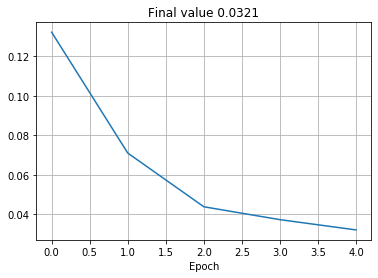

In [8]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [9]:
autoencoder.eval()
data, targets = next(test_loader.__iter__())
encodings = encoder(Variable(data))
outputs = decoder(encodings)

print('Test loss: {:.4f}'.format(loss_fn(outputs, Variable(data)).item()))

Test loss: 0.0295


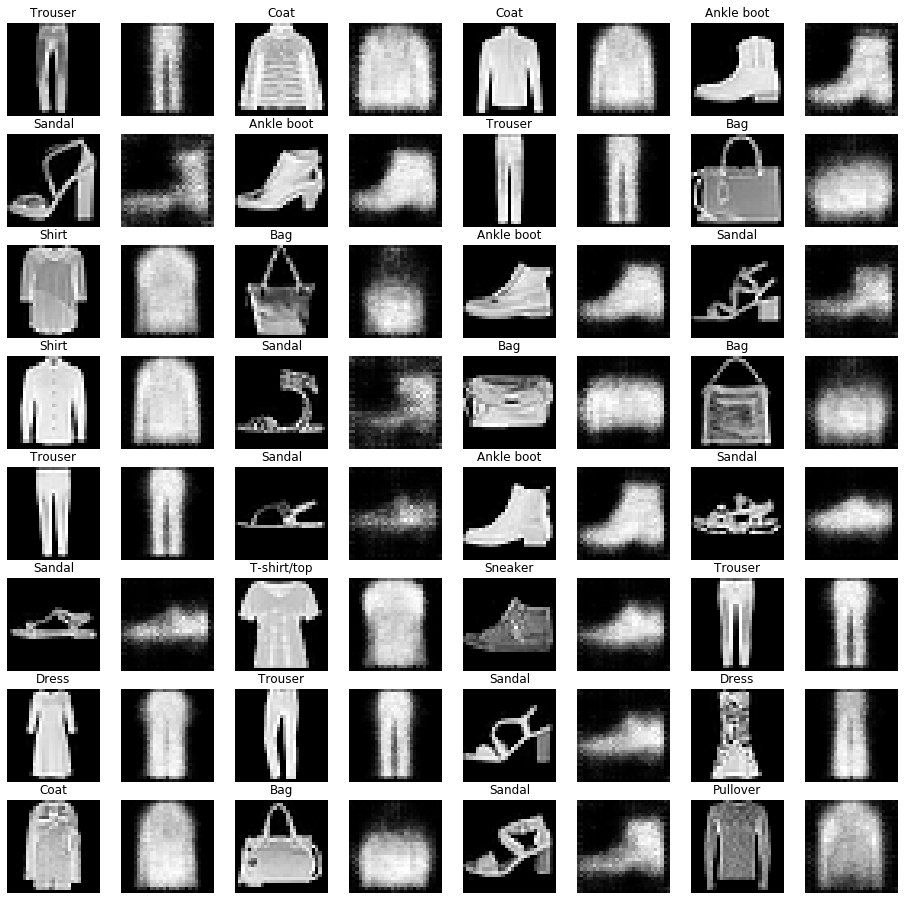

In [10]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.ravel()

zip_these = axes[::2], axes[1::2], data.numpy().squeeze(), outputs.data.numpy().squeeze(), targets
for ax1, ax2, original, reconstructed, target in zip(*zip_these):
    ax1.imshow(original, cmap='gray')
    ax1.axis('off')
    ax1.set_title(FASHION_MNIST_CLASSES[target])
    ax2.imshow(reconstructed, cmap='gray')
    ax2.axis('off')

### Embeddings

The embeddings are 20-dimensional, t-SNE is used to visualize them as clusters in 2D space.

Even though the autoencoder learned the embeddings in a completely unsupervised way we can observe the emergence of clusters:
- __shoes__ (sandals, sneakers and ankle boot) are clustered together
- __bags__ form a group on their own (they are the only images with a clear squared-rectangular shape)
- same goes for __trousers__, that form their own group
- all the others are quite mixed together, meaning that the network has learned the concept of _clothes for the upper body_, but is not able to tell a __coat__ from a __pullover__

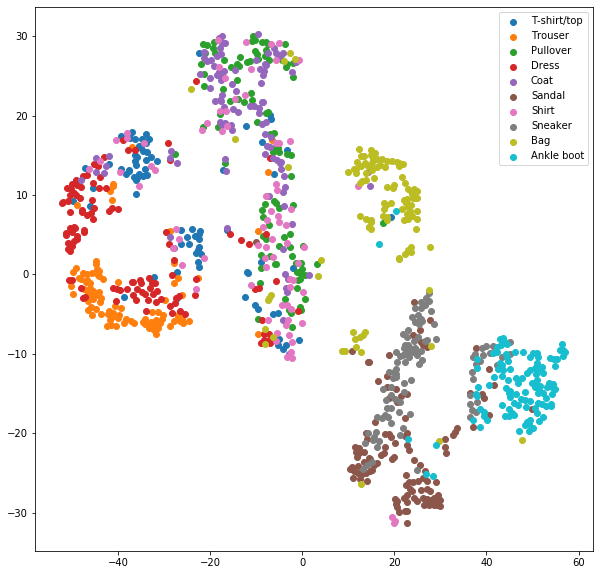

In [11]:
pca = TSNE(n_components=2)
encodings_2 = pca.fit_transform(encodings.data.numpy())
plt.figure(figsize=(10, 10))
for k in range(len(FASHION_MNIST_CLASSES)):
    class_indexes = (targets.numpy() == k)
    plt.scatter(encodings_2[class_indexes, 0], encodings_2[class_indexes, 1], label=FASHION_MNIST_CLASSES[k])
plt.legend();

## Supervised classification

Once trained in an unsupervised fashion, the encoder module can be used to generate _fashion_ embeddings (see what I did here?), that can then be used to train a simple classifier on the original labels.

### Model
The weights of the encoder are freezed, so only the classifier will be trained.

(later on, when the classifier starts performing decently, we could unfreeze them and do some fine-tuning)

In [12]:
for param in encoder.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    encoder, 
    nn.Linear(embedding_size, 15),
    nn.ReLU(),
    nn.Linear(15, len(FASHION_MNIST_CLASSES)),
    nn.LogSoftmax()
)

### Training

In [13]:
classifier.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam([p for p in classifier.parameters() if p.requires_grad])
epoch_loss = []

for epoch in range(5):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

/opt/conda/envs/bentoml-dev-py36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0:	loss 2.3179	accuracy 45.70%
Epoch 1:	loss 1.2234	accuracy 59.00%
Epoch 2:	loss 1.0394	accuracy 62.90%
Epoch 3:	loss 0.9558	accuracy 63.00%
Epoch 4:	loss 0.9095	accuracy 68.10%


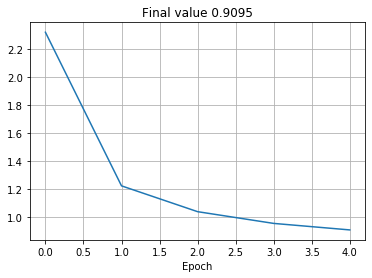

In [14]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [15]:
classifier.eval()
data, targets = next(test_loader.__iter__())
outputs = classifier(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 64.70%


/opt/conda/envs/bentoml-dev-py36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


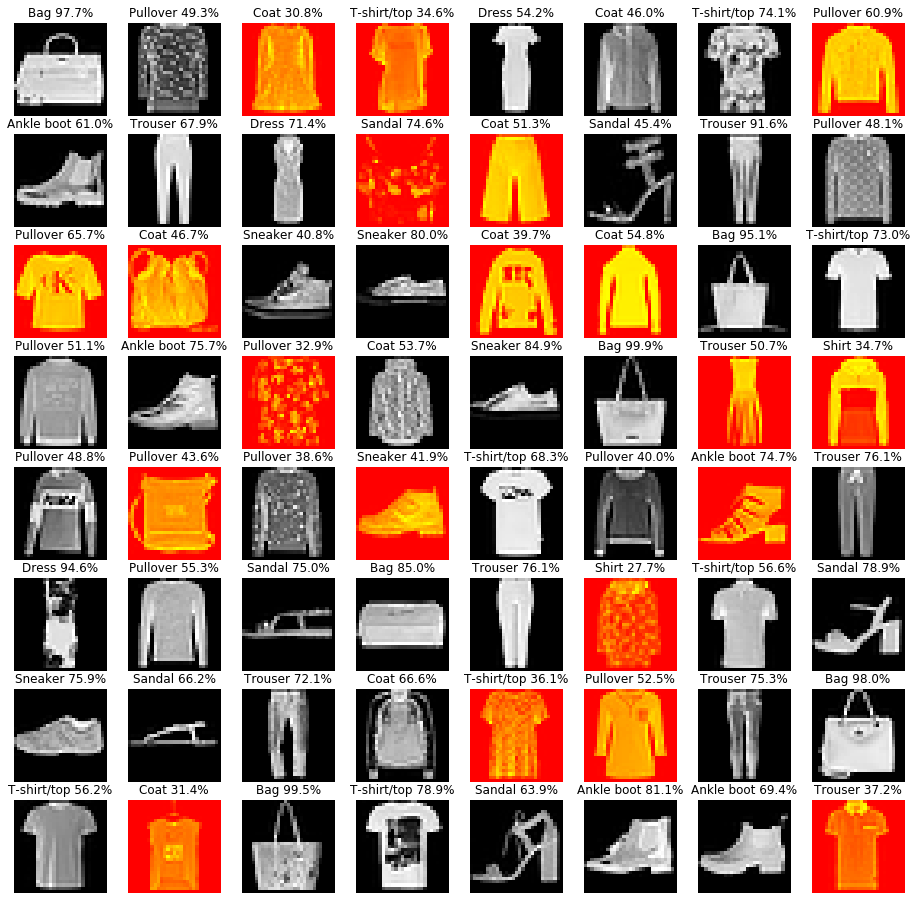

In [16]:
fig, axex = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axex.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img, cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FASHION_MNIST_CLASSES[output_class], prob))

## Define BentoService for model serving

In [28]:
%%writefile pytorch_fashion_mnist.py

from typing import BinaryIO, List

import bentoml
from PIL import Image
import torch
from torchvision import transforms

from bentoml.frameworks.pytorch import PytorchModelArtifact
from bentoml.adapters import FileInput, JsonOutput


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_packages=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('classifier')])
class PyTorchFashionClassifier(bentoml.BentoService):
    
    @bentoml.utils.cached_property  # reuse transformer
    def transform(self):
        return transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()])

    @bentoml.api(input=FileInput(), output=JsonOutput(), batch=True)
    def predict(self, file_streams: List[BinaryIO]) -> List[str]:
        img_tensors = []
        for fs in file_streams:
            img = Image.open(fs).convert(mode="L").resize((28, 28))
            img_tensors.append(self.transform(img))
        outputs = self.artifacts.classifier(torch.stack(img_tensors))
        _, output_classes = outputs.max(dim=1)
        
        return [FASHION_MNIST_CLASSES[output_class] for output_class in output_classes]

Overwriting pytorch_fashion_mnist.py


## Save BentoService


In [18]:
# 1) import the custom BentoService defined above
from pytorch_fashion_mnist import PyTorchFashionClassifier

# 2) `pack` it with required artifacts
bento_svc = PyTorchFashionClassifier()
bento_svc.pack('classifier', classifier)

# 3) save your BentoSerivce
saved_path = bento_svc.save()

[2020-09-23 11:40:29,693] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:40:29,733] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-23 11:40:29,734] WARNING - pip package requirement torch already exist
[2020-09-23 11:40:31,270] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


/opt/conda/envs/bentoml-dev-py36/lib/python3.6/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
/opt/conda/envs/bentoml-dev-py36/lib/python3.6/site-packages/setuptools/dist.py:458: UserWarning: Normalizing '0.9.0.pre+7.g8af1c8b' to '0.9.0rc0+7.g8af1c8b'
  warnings.warn(tmpl.format(**locals()))
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.9.0rc0+7.g8af1c8b/bentoml/_version.py
set BentoML-0.9.0rc0+7.g8af1c8b/bentoml/_version.py to '0.9.0.pre+7.g8af1c8b'
[2020-09-23 11:40:32,018] INFO - BentoService bundle 'PyTorchFashionClassifier:20200923114030_0CC108' saved to: /home/bentoml/bentoml/repository/PyTorchFashionClassifier/20200923114030_0CC108


## REST API Model Serving


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [22]:
!bentoml serve PyTorchFashionClassifier:latest

[2020-09-23 11:42:36,540] INFO - Getting latest version PyTorchFashionClassifier:20200923114030_0CC108
[2020-09-23 11:42:36,541] INFO - Starting BentoML API server in development mode..
[2020-09-23 11:42:37,708] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:42:37,722] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 11:42:38,187] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

In [21]:
!bentoml serve PyTorchFashionClassifier:latest --run-with-ngrok

[2020-09-23 11:41:46,832] INFO - Getting latest version PyTorchFashionClassifier:20200923114030_0CC108
[2020-09-23 11:41:46,833] INFO - Starting BentoML API server in development mode..
[2020-09-23 11:41:47,995] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:41:48,010] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 11:41:48,473] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a

### Call REST API from a client

Sending POST request from termnial:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

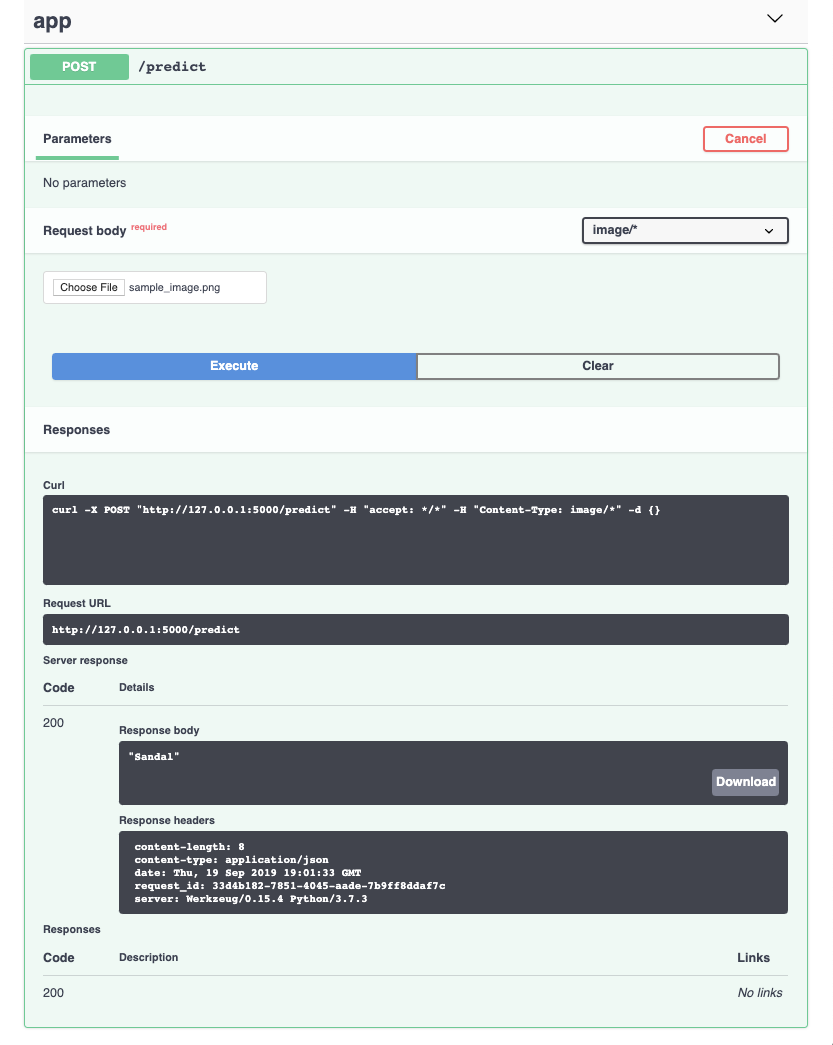

## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [25]:
!bentoml containerize PyTorchFashionClassifier:latest -t pytorch-fashion-mnist:latest

[2020-09-23 11:48:08,611] INFO - Getting latest version PyTorchFashionClassifier:20200923114030_0CC108
Found Bento: /home/bentoml/bentoml/repository/PyTorchFashionClassifier/20200923114030_0CC108
[2020-09-23 11:48:08,628] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:48:08,642] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
Building Docker image pytorch-fashion-mnist:latest from PyTorchFashionClassifier:latest 
-Step 1/15 : FROM bentoml/model-server:0.9.0.pre-py36
 ---> 4aac43d10e50
Step 2/15 : ARG EXTRA_PIP_INSTALL_ARGS=
 ---> Using cache
 ---> 790054f5ad85
Step 3/15 : ENV EXTRA_PIP_INSTALL_ARGS $EXTRA_PIP_INSTALL_ARGS
 ---> Using cache
 ---> 85b0a1b40542
Step

In [26]:
!docker run -p 5000:5000 pytorch-fashion-mnist

[2020-09-23 03:48:13,508] INFO - Starting BentoML API server in production mode..
[2020-09-23 03:48:13,728] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-09-23 03:48:13 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-09-23 03:48:13 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-09-23 03:48:13 +0000] [1] [INFO] Using worker: sync
[2020-09-23 03:48:13 +0000] [12] [INFO] Booting worker with pid: 12
[2020-09-23 03:48:13 +0000] [13] [INFO] Booting worker with pid: 13
[2020-09-23 03:48:13 +0000] [14] [INFO] Booting worker with pid: 14
[2020-09-23 03:48:14,747] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deploying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-09-23 03:48:14,767] WARNING - Saved BentoService bundle version mismatch

## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [29]:
!bentoml run PyTorchFashionClassifier:latest predict --input-file sample_image.png

[2020-09-23 11:57:28,103] INFO - Getting latest version PyTorchFashionClassifier:20200923114030_0CC108
[2020-09-23 11:57:28,167] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:57:28,182] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 11:57:28,646] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-23 11:57:28,647] WARNING - pip package requirement torch alr

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)